In [1]:
import numpy as np
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter, ParameterVector

In [2]:
circ = QuantumCircuit(2, 2)
vector = [np.pi/2, np.pi/2]
circ.h([0, 1])
circ.initialize(vector, qubits=[0], normalize=True)
theta = Parameter("theta")
circ.ry(theta, 1)
circ.cx(0, 1)
circ.draw()

┌───┐┌─────────────────────────────┐     
q_0: ┤ H ├┤ Initialize(0.70711,0.70711) ├──■──
     ├───┤└────────┬───────────┬────────┘┌─┴─┐
q_1: ┤ H ├─────────┤ Ry(theta) ├─────────┤ X ├
     └───┘         └───────────┘         └───┘
c: 2/═════════════════════════════════════════

In [3]:
meas = QuantumCircuit(2, 2)
meas.measure(range(2), range(2))
# meas.draw()
sampler_circ = circ.compose(meas, qubits=[0, 1], clbits=[0, 1], inplace=False)
sampler_circ.draw()

┌───┐┌─────────────────────────────┐     ┌─┐   
q_0: ┤ H ├┤ Initialize(0.70711,0.70711) ├──■──┤M├───
     ├───┤└────────┬───────────┬────────┘┌─┴─┐└╥┘┌─┐
q_1: ┤ H ├─────────┤ Ry(theta) ├─────────┤ X ├─╫─┤M├
     └───┘         └───────────┘         └───┘ ║ └╥┘
c: 2/══════════════════════════════════════════╩══╩═
                                               0  1

In [4]:
# Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options
from qiskit.quantum_info import SparsePauliOp

In [31]:
# Initialize Runtime 
service = QiskitRuntimeService()

In [32]:
# Runtime Backend
# service.backends()
# service.least_busy(instance="hub/group/project", simulator=True)
backend = service.backend("ibmq_qasm_simulator")

In [7]:
# Options
# options = Options(optimization_level=3, resilience_level=0, transpilation={"initial_layout": [2, 3]})
options = Options(optimization_level=0, resilience_level=0)

In [8]:
# Sampler Session
with Session(service=service, backend=backend) as session:
    sampler = Sampler(session=session, options=options)
    job = sampler.run(sampler_circ, parameter_values=[np.pi/2], shots=1000)
    print(job.status())
    sampler_result = job.result()
    print(sampler_result)

JobStatus.RUNNING
SamplerResult(quasi_dists=[{2: 0.497, 1: 0.503}], metadata=[{'shots': 1000, 'circuit_metadata': {}}])


In [9]:
quasi_dists = sampler_result.quasi_dists
quasi_dists

[{2: 0.497, 1: 0.503}]

In [10]:
# Noise
# Import noisy backend
from qiskit_ibm_runtime.fake_provider import FakeMumbaiV2
from qiskit_aer.noise import NoiseModel

In [11]:
fake_backend = FakeMumbaiV2()
noise_model = NoiseModel.from_backend(fake_backend)
noise_model

<NoiseModel on ['x', 'id', 'measure', 'sx', 'cx', 'reset']>

In [19]:
# Sampler session
noise_options = Options(simulator={"noise_model": noise_model, "seed_simulator": 100}, resilience_level=0, optimization_level=0)
with Session(service=service, backend=backend) as session:
    sampler = Sampler(session=session, options=noise_options)
    job = sampler.run(sampler_circ, parameter_values=[np.pi/2], shots=1000)
    print(job.status())
    noise_results = job.result()
    print(noise_results)

JobStatus.RUNNING
SamplerResult(quasi_dists=[{3: 0.033, 0: 0.034, 2: 0.483, 1: 0.45}], metadata=[{'shots': 1000, 'circuit_metadata': {}}])


In [20]:
noisy_quasi_dists = noise_results.quasi_dists
noisy_quasi_dists

[{3: 0.033, 0: 0.034, 2: 0.483, 1: 0.45}]

In [16]:
# Error Mitigation
mitigation_options = Options(simulator={"noise_model": noise_model, "seed_simulator": 100}, resilience_level=1, optimization_level=0)
with Session(service=service, backend=backend) as session:
    sampler = Sampler(session=session, options=mitigation_options)
    job = sampler.run(sampler_circ, parameter_values=[np.pi/2], shots=1000)
    print(job.status())
    mitigated_results = job.result()
    print(mitigated_results)

JobStatus.RUNNING
SamplerResult(quasi_dists=[{0: 0.015477368388232, 1: 0.468506469659005, 2: 0.50218590203101, 3: 0.013830259921754}], metadata=[{'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.1851166427494901, 'readout_mitigation_time': 0.014904782176017761}])


In [17]:
mitigated_quasi_dists = mitigated_results.quasi_dists
mitigated_quasi_dists

[{0: 0.015477368388232, 1: 0.468506469659005, 2: 0.50218590203101, 3: 0.013830259921754}]

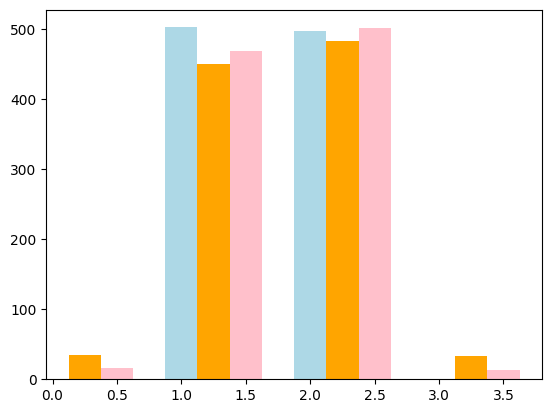

In [21]:
import matplotlib.pyplot as plt

# Compare Results
x = range(4)

# Ideal
for k, v in quasi_dists[0].items():
    plt.bar(x[k] + 0, v*1000, color="lightblue", width=0.25)

# Noisy
for k, v in noisy_quasi_dists[0].items():
    plt.bar(x[k] + 0.25, v*1000, color="orange", width=0.25)

# Mitigated
for k, v in mitigated_quasi_dists[0].items():
    plt.bar(x[k] + 0.5, v*1000, color="pink", width=0.25)

plt.show()

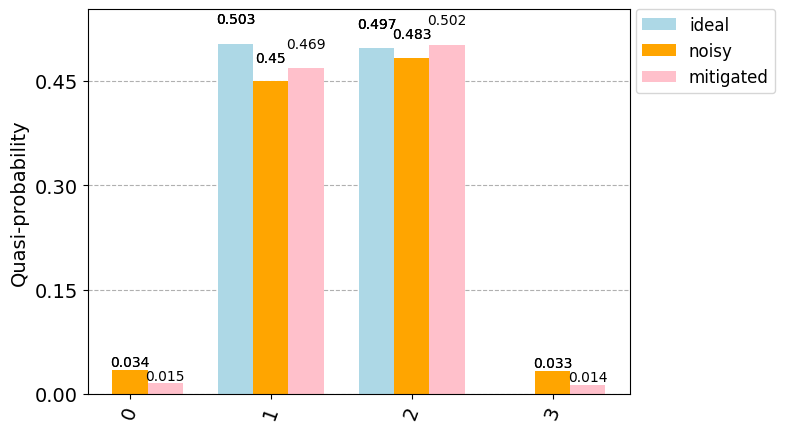

In [38]:
from qiskit.visualization import plot_distribution

plot_distribution([quasi_dists[0], noisy_quasi_dists[0], mitigated_quasi_dists[0]], legend=["ideal", "noisy", "mitigated"], color=["lightblue", "orange", "pink"])

In [23]:
# Observables
observables = SparsePauliOp(["ZZ"])

In [33]:
# Estimator
with Session(service=service, backend=backend) as session:
    estimator = Estimator(session=session, options=options)
    job = estimator.run(circ, observables=observables, parameter_values=[np.pi/2], shots=1000)
    estimator_results = job.result()
    print(estimator_results)

EstimatorResult(values=array([-1.]), metadata=[{'variance': 0.0, 'shots': 1000}])


In [36]:
# Expectation Value
estimator_values = estimator_results.values
estimator_values

array([-1.])